## Pre-Trained Model 활용 인터넷 사이트 캡차 숫자인식하기
ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)란 컴퓨터 비전 분야의 '올림픽'으로 불리우는 대회이다. 아마도 딥러닝을 공부한 사람들이라면 한번 쯤 AlexNet이나 VGG, GoogleNet, ResNet에 대해 들어보았을 것이다. 이는 모두 ILSVRC 대회에서 매년 우승을 거머쥐었던 모델이다.
![ImageNet Classfication](images/MicrosoftImagNetResults.png)

출처 : https://www.bdti.com/InsideDSP/2017/06/29/Microsoft

Tranfer Learning과 ILSVRC가 무슨 연관이 있지? 라는 생각이 들텐데, 놀랍게도 우리는 ImageNet Classfication 대회에서 우승했던 모델과 그 가중치를 가져와 쓸 수 있는데, 이것이 바로 앞서 언급 했던 Pre-Trained Model이다.
![ResNet34](images/resnet34.png)

도대체 어떻게하면 이렇게 'Deep한' 모델을 가져다 쓸 수 있을까.

**model_ft = models.resnet18(pretrained=True)** 오늘의 핵심을 단 한 줄로 설명하면 바로 이 코드가 되겠다. torchvision 라이브러리에서는 ResNet 시리즈와 VGG 시리즈 등 ImageNet의 모든 대표작들을 잘 구현해 놓았다. 따라서 우리는 라이브러리에서 꺼내 쓰기만 하면 되는 것이다. 또한 Pre-Trained Weights의 경우, 모델을 불러올 때 파라미터로 pretrained=True 값만 입력해주면 자동으로 Weights 값을 불러올 수 있다.


**```model_ft = models.resnet18(pretrained=True)```**


여기서는 Pre-Trained Model을 캡차 이미지의 숫자인식 성능을 높이기 위해 Weights 값은 제외하고 ResNet에 사용된 알고리즘 모델만 이용 하겠으며,

**```model_ft = models.resnet18(pretrained=False)```**


이상과 같이 pretrained=False로 주고 활용 하게 됩니다.

신경망의 일반적인 학습 과정은 다음과 같습니다:

- 학습 가능한 매개변수(또는 가중치(weight))를 갖는 신경망을 정의합니다.

- 데이터셋(dataset) 입력을 반복합니다.

- 입력을 신경망에서 전파(process)합니다.

- 손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

- 변화도(gradient)를 신경망의 매개변수들에 역으로 전파합니다.

- 신경망의 가중치를 갱신합니다. 일반적으로 다음과 같은 간단한 규칙을 사용합니다: 가중치(wiehgt) = 가중치(weight) - 학습율(learning rate) * 변화도(gradient)

In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy


### 목적변수 처리를 위한 OneHot Vector 생성준비



In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 5

In [3]:
print("ALL_CHAR_SET : {}".format(ALL_CHAR_SET))
print("ALL_CHAR_SET_LEN : {}".format(ALL_CHAR_SET_LEN))

ALL_CHAR_SET : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET_LEN : 36


### One - Hot Labels

이제 우리의 정답 y를 one hot vector로 바꿉시다.

one hot vector이란 모든 벡터의 원소들 중 하나만 1인 벡터를 의미합니다.

예를 들어, one hot vector로 0를 표현하면 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 이 될 수 있겠죠.(36개)


In [4]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [5]:
encode('0')
len(encode('0'))
print("encode('0') : {}".format(encode('0')))
print("len(encode('0')) : {}".format(len(encode('0'))))


encode('0') : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(encode('0')) : 36


### 종속변수 처리를 위한 데이터셋 불러오기
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

* 처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [6]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [7]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [8]:
train_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), transform=transform)
test_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(train_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


일부 이미지 시각화하기 ^^^^^^^^^^^^^^^^^^^^^^^^^ 데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

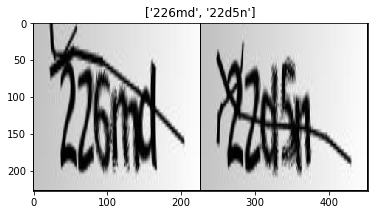

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:2])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:2]])



In [10]:
print("inputs")
print(inputs[0])
print(inputs.size())

inputs
tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]]])
torch.Size([64, 1, 224, 224])


In [11]:
print("label_oh")
print(label_oh[0])
print(label_oh.size())

label_oh
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
torch.Size([64, 180])


In [12]:
print("classes")
print(classes[0])
print(len(classes))

classes
226md
64


### ResNet18 모델기반 신경망 정의하기

이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LEN*MAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LEN*MAX_CAPTCHA가 된다.

In [13]:
def get_model():
    """
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
    return model

# 모델 정의 
model = get_model().to(device)


### 손실함수정의

In [14]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### 모델 학습하기


In [15]:
since = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    print(' ' * 50)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).to(device)
        label_oh = Variable(label_oh.float()).to(device)
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('step:', step+1, 'loss:', loss.item())

time_elapsed = time.time() - since
print('=' * 50)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


                                                  
Epoch 1/50
----------
step: 1 loss: 0.7387230396270752
step: 2 loss: 0.5346273183822632
step: 3 loss: 0.3633025288581848
step: 4 loss: 0.24699369072914124
step: 5 loss: 0.18047238886356354
step: 6 loss: 0.1477515995502472
step: 7 loss: 0.13278718292713165
step: 8 loss: 0.1257621943950653
step: 9 loss: 0.124485082924366
step: 10 loss: 0.13050493597984314
step: 11 loss: 0.1316152662038803
step: 12 loss: 0.13339030742645264
step: 13 loss: 0.13171781599521637
step: 14 loss: 0.1274048388004303
step: 15 loss: 0.12798762321472168
step: 16 loss: 0.1252261847257614
                                                  
Epoch 2/50
----------
step: 1 loss: 0.12264552712440491
step: 2 loss: 0.12315697222948074
step: 3 loss: 0.11972381174564362
step: 4 loss: 0.11635592579841614
step: 5 loss: 0.11496943235397339
step: 6 loss: 0.11174915730953217
step: 7 loss: 0.11222845315933228
step: 8 loss: 0.11106432229280472
step: 9 loss: 0.11191748827695847
step: 1

step: 3 loss: 0.06901606917381287
step: 4 loss: 0.06795261800289154
step: 5 loss: 0.07023707032203674
step: 6 loss: 0.06811145693063736
step: 7 loss: 0.06921442598104477
step: 8 loss: 0.06297920644283295
step: 9 loss: 0.062393128871917725
step: 10 loss: 0.06792718172073364
step: 11 loss: 0.06657106429338455
step: 12 loss: 0.07493653893470764
step: 13 loss: 0.0666748583316803
step: 14 loss: 0.06208552420139313
step: 15 loss: 0.07264357805252075
step: 16 loss: 0.06078200414776802
                                                  
Epoch 15/50
----------
step: 1 loss: 0.06506165117025375
step: 2 loss: 0.06431876122951508
step: 3 loss: 0.06223532557487488
step: 4 loss: 0.06039441004395485
step: 5 loss: 0.0634520947933197
step: 6 loss: 0.06226680427789688
step: 7 loss: 0.06364156305789948
step: 8 loss: 0.05733335018157959
step: 9 loss: 0.0576438307762146
step: 10 loss: 0.060477666556835175
step: 11 loss: 0.06107596307992935
step: 12 loss: 0.06999567151069641
step: 13 loss: 0.0602478235960006

step: 3 loss: 0.017282545566558838
step: 4 loss: 0.017340516671538353
step: 5 loss: 0.01706438884139061
step: 6 loss: 0.023231344297528267
step: 7 loss: 0.01964360475540161
step: 8 loss: 0.01556480210274458
step: 9 loss: 0.01782819628715515
step: 10 loss: 0.016041211783885956
step: 11 loss: 0.019930828362703323
step: 12 loss: 0.024922996759414673
step: 13 loss: 0.022821225225925446
step: 14 loss: 0.01400287076830864
step: 15 loss: 0.016040422022342682
step: 16 loss: 0.021560613065958023
                                                  
Epoch 28/50
----------
step: 1 loss: 0.02090815268456936
step: 2 loss: 0.017058197408914566
step: 3 loss: 0.014804304577410221
step: 4 loss: 0.015533450059592724
step: 5 loss: 0.015829473733901978
step: 6 loss: 0.022295165807008743
step: 7 loss: 0.019792277365922928
step: 8 loss: 0.017090125009417534
step: 9 loss: 0.012839371338486671
step: 10 loss: 0.013111467473208904
step: 11 loss: 0.017966171726584435
step: 12 loss: 0.02361436001956463
step: 13 loss

step: 1 loss: 0.004226382821798325
step: 2 loss: 0.003928296267986298
step: 3 loss: 0.004089813679456711
step: 4 loss: 0.0037962838541716337
step: 5 loss: 0.004064657725393772
step: 6 loss: 0.005652670282870531
step: 7 loss: 0.004357635509222746
step: 8 loss: 0.0032067750580608845
step: 9 loss: 0.0030113295651972294
step: 10 loss: 0.003301111748442054
step: 11 loss: 0.00462107639759779
step: 12 loss: 0.007167464587837458
step: 13 loss: 0.007270697504281998
step: 14 loss: 0.0035723967012017965
step: 15 loss: 0.003559524891898036
step: 16 loss: 0.004794578533619642
                                                  
Epoch 41/50
----------
step: 1 loss: 0.004933294840157032
step: 2 loss: 0.005009583663195372
step: 3 loss: 0.003313518362119794
step: 4 loss: 0.0032342986669391394
step: 5 loss: 0.0031028087250888348
step: 6 loss: 0.004886184819042683
step: 7 loss: 0.003946251701563597
step: 8 loss: 0.002863881178200245
step: 9 loss: 0.002671952359378338
step: 10 loss: 0.0027327961288392544
st

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_correct = 0
    test_total = len(test_dl.dataset)

    with torch.no_grad():
        for i, (inputs, label_oh, label) in enumerate(test_dl):
            
            view_image = torchvision.utils.make_grid(inputs)
            inputs = Variable(inputs).to(device)
#             labels = labels.to(device)

            outputs = model(inputs)
    
            c0 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
            c1 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
            c2 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
            c3 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
            c4 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
            preds_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

            correct = ""
            if label[0] == preds_label:
                test_correct += 1
                correct = "True"
            else:
                correct = "False"
                
            
            print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

            # 맞추지 못한 이미지를 출력한다.
            if (correct == "False") and (num_images > i):
                imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

        model.train(mode=was_training)
        
    print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')


### 모델 학습결과 테스트 데이터로 테스트

In [17]:
visualize_model(model)

Lable : 226md Prediction Lable : 226md 맟춤여부 : True
Lable : 22d5n Prediction Lable : 22d5n 맟춤여부 : True
Lable : 2356g Prediction Lable : 2356g 맟춤여부 : True
Lable : 23mdg Prediction Lable : 23mdg 맟춤여부 : True
Lable : 23n88 Prediction Lable : 23n88 맟춤여부 : True
Lable : 243mm Prediction Lable : 243mm 맟춤여부 : True
Lable : 244e2 Prediction Lable : 244e2 맟춤여부 : True
Lable : 245y5 Prediction Lable : 245y5 맟춤여부 : True
Lable : 24f6w Prediction Lable : 24f6w 맟춤여부 : True
Lable : 24pew Prediction Lable : 24pew 맟춤여부 : True
Lable : 25257 Prediction Lable : 25257 맟춤여부 : True
Lable : 253dc Prediction Lable : 253dc 맟춤여부 : True
Lable : 25egp Prediction Lable : 25egp 맟춤여부 : True
Lable : 25m6p Prediction Lable : 25m6p 맟춤여부 : True
Lable : 25p2m Prediction Lable : 25p2m 맟춤여부 : True
Lable : 25w53 Prediction Lable : 25w53 맟춤여부 : True
Lable : 264m5 Prediction Lable : 264m5 맟춤여부 : True
Lable : 268g2 Prediction Lable : 268g2 맟춤여부 : True
Lable : 28348 Prediction Lable : 28348 맟춤여부 : True
Lable : 28x47 Prediction Lable 

Lable : 57gnx Prediction Lable : 57gnx 맟춤여부 : True
Lable : 57wdp Prediction Lable : 57wdp 맟춤여부 : True
Lable : 58b5m Prediction Lable : 58b5m 맟춤여부 : True
Lable : 58pnp Prediction Lable : 58pnp 맟춤여부 : True
Lable : 5bb66 Prediction Lable : 5bb66 맟춤여부 : True
Lable : 5bg8f Prediction Lable : 5bg8f 맟춤여부 : True
Lable : 5bgp2 Prediction Lable : 5bgp2 맟춤여부 : True
Lable : 5bnd7 Prediction Lable : 5bnd7 맟춤여부 : True
Lable : 5dxnm Prediction Lable : 5dxnm 맟춤여부 : True
Lable : 5ep3n Prediction Lable : 5ep3n 맟춤여부 : True
Lable : 5expp Prediction Lable : 5expp 맟춤여부 : True
Lable : 5f3gf Prediction Lable : 5f3gf 맟춤여부 : True
Lable : 5fyem Prediction Lable : 5fyem 맟춤여부 : True
Lable : 5g5e5 Prediction Lable : 5g5e5 맟춤여부 : True
Lable : 5gcd3 Prediction Lable : 5gcd3 맟춤여부 : True
Lable : 5mcy7 Prediction Lable : 5mcy7 맟춤여부 : True
Lable : 5mf7c Prediction Lable : 5mf7c 맟춤여부 : True
Lable : 5mfff Prediction Lable : 5mfff 맟춤여부 : True
Lable : 5mgn4 Prediction Lable : 5mgn4 맟춤여부 : True
Lable : 5mnpd Prediction Lable 

Lable : 8bbw8 Prediction Lable : 8bbw8 맟춤여부 : True
Lable : 8c23f Prediction Lable : 8c23f 맟춤여부 : True
Lable : 8c2wy Prediction Lable : 8c2wy 맟춤여부 : True
Lable : 8cccc Prediction Lable : 8cccc 맟춤여부 : True
Lable : 8cm46 Prediction Lable : 8cm46 맟춤여부 : True
Lable : 8d2nd Prediction Lable : 8d2nd 맟춤여부 : True
Lable : 8d4wm Prediction Lable : 8d4wm 맟춤여부 : True
Lable : 8d8ep Prediction Lable : 8d8ep 맟춤여부 : True
Lable : 8db67 Prediction Lable : 8db67 맟춤여부 : True
Lable : 8e32m Prediction Lable : 8e32m 맟춤여부 : True
Lable : 8eggg Prediction Lable : 8eggg 맟춤여부 : True
Lable : 8fexn Prediction Lable : 8fexn 맟춤여부 : True
Lable : 8g4yp Prediction Lable : 8g4yp 맟춤여부 : True
Lable : 8gecm Prediction Lable : 8gecm 맟춤여부 : True
Lable : 8gf7n Prediction Lable : 8gf7n 맟춤여부 : True
Lable : 8gmc4 Prediction Lable : 8gmc4 맟춤여부 : True
Lable : 8gmnx Prediction Lable : 8gmnx 맟춤여부 : True
Lable : 8n2pg Prediction Lable : 8n2pg 맟춤여부 : True
Lable : 8n34n Prediction Lable : 8n34n 맟춤여부 : True
Lable : 8n4n8 Prediction Lable 

Lable : d66cn Prediction Lable : d66cn 맟춤여부 : True
Lable : d6fcn Prediction Lable : d6fcn 맟춤여부 : True
Lable : d75b5 Prediction Lable : d75b5 맟춤여부 : True
Lable : d7c5x Prediction Lable : d7c5x 맟춤여부 : True
Lable : d7en3 Prediction Lable : d7en3 맟춤여부 : True
Lable : d7nn3 Prediction Lable : d7nn3 맟춤여부 : True
Lable : d8dce Prediction Lable : d8dce 맟춤여부 : True
Lable : d8xcn Prediction Lable : d8xcn 맟춤여부 : True
Lable : dbex3 Prediction Lable : dbex3 맟춤여부 : True
Lable : dbfen Prediction Lable : dbfen 맟춤여부 : True
Lable : dbny3 Prediction Lable : dbny3 맟춤여부 : True
Lable : dbpcd Prediction Lable : dbpcd 맟춤여부 : True
Lable : dc436 Prediction Lable : dc436 맟춤여부 : True
Lable : dce8y Prediction Lable : dce8y 맟춤여부 : True
Lable : dcnp8 Prediction Lable : dcnp8 맟춤여부 : True
Lable : dd5w5 Prediction Lable : dd5w5 맟춤여부 : True
Lable : dd764 Prediction Lable : dd764 맟춤여부 : True
Lable : ddcdd Prediction Lable : ddcdd 맟춤여부 : True
Lable : ddcne Prediction Lable : ddcne 맟춤여부 : True
Lable : ddmyg Prediction Lable 

Lable : ggd7m Prediction Lable : ggd7m 맟춤여부 : True
Lable : gm2c2 Prediction Lable : gm2c2 맟춤여부 : True
Lable : gm6nn Prediction Lable : gm6nn 맟춤여부 : True
Lable : gm7n8 Prediction Lable : gm7n8 맟춤여부 : True
Lable : gmmne Prediction Lable : gmmne 맟춤여부 : True
Lable : gn2d3 Prediction Lable : gn2d3 맟춤여부 : True
Lable : gn2xy Prediction Lable : gn2xy 맟춤여부 : True
Lable : gnbde Prediction Lable : gnbde 맟춤여부 : True
Lable : gnbn4 Prediction Lable : gnbn4 맟춤여부 : True
Lable : gnc3n Prediction Lable : gnc3n 맟춤여부 : True
Lable : gnf85 Prediction Lable : gnf85 맟춤여부 : True
Lable : gng6e Prediction Lable : gng6e 맟춤여부 : True
Lable : gny6b Prediction Lable : gny6b 맟춤여부 : True
Lable : gp22x Prediction Lable : gp22x 맟춤여부 : True
Lable : gp7c5 Prediction Lable : gp7c5 맟춤여부 : True
Lable : gpnxn Prediction Lable : gpnxn 맟춤여부 : True
Lable : gpxng Prediction Lable : gpxng 맟춤여부 : True
Lable : gw468 Prediction Lable : gw468 맟춤여부 : True
Lable : gw53m Prediction Lable : gw53m 맟춤여부 : True
Lable : gwn53 Prediction Lable 

Lable : ny3nn Prediction Lable : ny3nn 맟춤여부 : True
Lable : ny5dp Prediction Lable : ny5dp 맟춤여부 : True
Lable : ny8np Prediction Lable : ny8np 맟춤여부 : True
Lable : nybcx Prediction Lable : nybcx 맟춤여부 : True
Lable : p24gn Prediction Lable : p24gn 맟춤여부 : True
Lable : p2dw7 Prediction Lable : p2dw7 맟춤여부 : True
Lable : p2m6n Prediction Lable : p2m6n 맟춤여부 : True
Lable : p2x7x Prediction Lable : p2x7x 맟춤여부 : True
Lable : p2ym2 Prediction Lable : p2ym2 맟춤여부 : True
Lable : p4nm4 Prediction Lable : p4nm4 맟춤여부 : True
Lable : p4pde Prediction Lable : p4pde 맟춤여부 : True
Lable : p57fn Prediction Lable : p57fn 맟춤여부 : True
Lable : p5g5m Prediction Lable : p5g5m 맟춤여부 : True
Lable : p5nce Prediction Lable : p5nce 맟춤여부 : True
Lable : p6mn8 Prediction Lable : p6mn8 맟춤여부 : True
Lable : p7fyp Prediction Lable : p7fyp 맟춤여부 : True
Lable : p8c24 Prediction Lable : p8c24 맟춤여부 : True
Lable : p8ngx Prediction Lable : p8ngx 맟춤여부 : True
Lable : p8wwf Prediction Lable : p8wwf 맟춤여부 : True
Lable : pbpgc Prediction Lable 

<Figure size 432x288 with 0 Axes>

### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [18]:
torch.save(model.state_dict(), 'model/CaptchaBreaking_Model.pt')
print("save last model")


save last model


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 CaptchaBreaking_Model.pt 라는 파일이 생성됩니다.

아래 코드처럼 CaptchaBreaking_Model.pt를 다시 load하는 것도 가능합니다.

In [19]:
new_model = get_model().to(device)
new_model = new_model.eval()
new_model.load_state_dict(torch.load('model/CaptchaBreaking_Model.pt'))
print("load saved_model.")


load saved_model.


업로드한 모델로 다시한번 테스트

In [20]:
visualize_model(new_model)

Lable : 226md Prediction Lable : 226md 맟춤여부 : True
Lable : 22d5n Prediction Lable : 22d5n 맟춤여부 : True
Lable : 2356g Prediction Lable : 2356g 맟춤여부 : True
Lable : 23mdg Prediction Lable : 23mdg 맟춤여부 : True
Lable : 23n88 Prediction Lable : 23n88 맟춤여부 : True
Lable : 243mm Prediction Lable : 243mm 맟춤여부 : True
Lable : 244e2 Prediction Lable : 244e2 맟춤여부 : True
Lable : 245y5 Prediction Lable : 245y5 맟춤여부 : True
Lable : 24f6w Prediction Lable : 24f6w 맟춤여부 : True
Lable : 24pew Prediction Lable : 24pew 맟춤여부 : True
Lable : 25257 Prediction Lable : 25257 맟춤여부 : True
Lable : 253dc Prediction Lable : 253dc 맟춤여부 : True
Lable : 25egp Prediction Lable : 25egp 맟춤여부 : True
Lable : 25m6p Prediction Lable : 25m6p 맟춤여부 : True
Lable : 25p2m Prediction Lable : 25p2m 맟춤여부 : True
Lable : 25w53 Prediction Lable : 25w53 맟춤여부 : True
Lable : 264m5 Prediction Lable : 264m5 맟춤여부 : True
Lable : 268g2 Prediction Lable : 268g2 맟춤여부 : True
Lable : 28348 Prediction Lable : 28348 맟춤여부 : True
Lable : 28x47 Prediction Lable 

Lable : 5gcd3 Prediction Lable : 5gcd3 맟춤여부 : True
Lable : 5mcy7 Prediction Lable : 5mcy7 맟춤여부 : True
Lable : 5mf7c Prediction Lable : 5mf7c 맟춤여부 : True
Lable : 5mfff Prediction Lable : 5mfff 맟춤여부 : True
Lable : 5mgn4 Prediction Lable : 5mgn4 맟춤여부 : True
Lable : 5mnpd Prediction Lable : 5mnpd 맟춤여부 : True
Lable : 5n245 Prediction Lable : 5n245 맟춤여부 : True
Lable : 5n3w4 Prediction Lable : 5n3w4 맟춤여부 : True
Lable : 5n728 Prediction Lable : 5n728 맟춤여부 : True
Lable : 5n732 Prediction Lable : 5n732 맟춤여부 : True
Lable : 5ng6e Prediction Lable : 5ng6e 맟춤여부 : True
Lable : 5nggg Prediction Lable : 5nggg 맟춤여부 : True
Lable : 5nm6d Prediction Lable : 5nm6d 맟춤여부 : True
Lable : 5nnff Prediction Lable : 5nnff 맟춤여부 : True
Lable : 5np4m Prediction Lable : 5np4m 맟춤여부 : True
Lable : 5npdn Prediction Lable : 5npdn 맟춤여부 : True
Lable : 5nxnn Prediction Lable : 5nxnn 맟춤여부 : True
Lable : 5p3mm Prediction Lable : 5p3mm 맟춤여부 : True
Lable : 5p8fm Prediction Lable : 5p8fm 맟춤여부 : True
Lable : 5pm6b Prediction Lable 

Lable : 8c23f Prediction Lable : 8c23f 맟춤여부 : True
Lable : 8c2wy Prediction Lable : 8c2wy 맟춤여부 : True
Lable : 8cccc Prediction Lable : 8cccc 맟춤여부 : True
Lable : 8cm46 Prediction Lable : 8cm46 맟춤여부 : True
Lable : 8d2nd Prediction Lable : 8d2nd 맟춤여부 : True
Lable : 8d4wm Prediction Lable : 8d4wm 맟춤여부 : True
Lable : 8d8ep Prediction Lable : 8d8ep 맟춤여부 : True
Lable : 8db67 Prediction Lable : 8db67 맟춤여부 : True
Lable : 8e32m Prediction Lable : 8e32m 맟춤여부 : True
Lable : 8eggg Prediction Lable : 8eggg 맟춤여부 : True
Lable : 8fexn Prediction Lable : 8fexn 맟춤여부 : True
Lable : 8g4yp Prediction Lable : 8g4yp 맟춤여부 : True
Lable : 8gecm Prediction Lable : 8gecm 맟춤여부 : True
Lable : 8gf7n Prediction Lable : 8gf7n 맟춤여부 : True
Lable : 8gmc4 Prediction Lable : 8gmc4 맟춤여부 : True
Lable : 8gmnx Prediction Lable : 8gmnx 맟춤여부 : True
Lable : 8n2pg Prediction Lable : 8n2pg 맟춤여부 : True
Lable : 8n34n Prediction Lable : 8n34n 맟춤여부 : True
Lable : 8n4n8 Prediction Lable : 8n4n8 맟춤여부 : True
Lable : 8n56m Prediction Lable 

Lable : dd5w5 Prediction Lable : dd5w5 맟춤여부 : True
Lable : dd764 Prediction Lable : dd764 맟춤여부 : True
Lable : ddcdd Prediction Lable : ddcdd 맟춤여부 : True
Lable : ddcne Prediction Lable : ddcne 맟춤여부 : True
Lable : ddmyg Prediction Lable : ddmyg 맟춤여부 : True
Lable : ddnpf Prediction Lable : ddnpf 맟춤여부 : True
Lable : ddpyb Prediction Lable : ddpyb 맟춤여부 : True
Lable : ddxpp Prediction Lable : ddxpp 맟춤여부 : True
Lable : de45x Prediction Lable : de45x 맟춤여부 : True
Lable : de7f8 Prediction Lable : de7f8 맟춤여부 : True
Lable : deep5 Prediction Lable : deep5 맟춤여부 : True
Lable : defyx Prediction Lable : defyx 맟춤여부 : True
Lable : deneb Prediction Lable : deneb 맟춤여부 : True
Lable : dfnx4 Prediction Lable : dfnx4 맟춤여부 : True
Lable : dgcm4 Prediction Lable : dgcm4 맟춤여부 : True
Lable : dmw8n Prediction Lable : dmw8n 맟춤여부 : True
Lable : dmx8p Prediction Lable : dmx8p 맟춤여부 : True
Lable : dmxp8 Prediction Lable : dmxp8 맟춤여부 : True
Lable : dn26n Prediction Lable : dn26n 맟춤여부 : True
Lable : dn2ym Prediction Lable 

Lable : gmmne Prediction Lable : gmmne 맟춤여부 : True
Lable : gn2d3 Prediction Lable : gn2d3 맟춤여부 : True
Lable : gn2xy Prediction Lable : gn2xy 맟춤여부 : True
Lable : gnbde Prediction Lable : gnbde 맟춤여부 : True
Lable : gnbn4 Prediction Lable : gnbn4 맟춤여부 : True
Lable : gnc3n Prediction Lable : gnc3n 맟춤여부 : True
Lable : gnf85 Prediction Lable : gnf85 맟춤여부 : True
Lable : gng6e Prediction Lable : gng6e 맟춤여부 : True
Lable : gny6b Prediction Lable : gny6b 맟춤여부 : True
Lable : gp22x Prediction Lable : gp22x 맟춤여부 : True
Lable : gp7c5 Prediction Lable : gp7c5 맟춤여부 : True
Lable : gpnxn Prediction Lable : gpnxn 맟춤여부 : True
Lable : gpxng Prediction Lable : gpxng 맟춤여부 : True
Lable : gw468 Prediction Lable : gw468 맟춤여부 : True
Lable : gw53m Prediction Lable : gw53m 맟춤여부 : True
Lable : gwn53 Prediction Lable : gwn53 맟춤여부 : True
Lable : gwnm6 Prediction Lable : gwnm6 맟춤여부 : True
Lable : gxx2p Prediction Lable : gxx2p 맟춤여부 : True
Lable : gxxpf Prediction Lable : gxxpf 맟춤여부 : True
Lable : gy433 Prediction Lable 

Lable : nwncn Prediction Lable : nwncn 맟춤여부 : True
Lable : nxc83 Prediction Lable : nxc83 맟춤여부 : True
Lable : nxcmn Prediction Lable : nxcmn 맟춤여부 : True
Lable : nxf2c Prediction Lable : nxf2c 맟춤여부 : True
Lable : nxn4f Prediction Lable : nxn4f 맟춤여부 : True
Lable : nxx25 Prediction Lable : nxx25 맟춤여부 : True
Lable : nxxf8 Prediction Lable : nxxf8 맟춤여부 : True
Lable : ny3dw Prediction Lable : ny3dw 맟춤여부 : True
Lable : ny3nn Prediction Lable : ny3nn 맟춤여부 : True
Lable : ny5dp Prediction Lable : ny5dp 맟춤여부 : True
Lable : ny8np Prediction Lable : ny8np 맟춤여부 : True
Lable : nybcx Prediction Lable : nybcx 맟춤여부 : True
Lable : p24gn Prediction Lable : p24gn 맟춤여부 : True
Lable : p2dw7 Prediction Lable : p2dw7 맟춤여부 : True
Lable : p2m6n Prediction Lable : p2m6n 맟춤여부 : True
Lable : p2x7x Prediction Lable : p2x7x 맟춤여부 : True
Lable : p2ym2 Prediction Lable : p2ym2 맟춤여부 : True
Lable : p4nm4 Prediction Lable : p4nm4 맟춤여부 : True
Lable : p4pde Prediction Lable : p4pde 맟춤여부 : True
Lable : p57fn Prediction Lable 

<Figure size 432x288 with 0 Axes>

### 학습모델이용 캡차 이미지 숫자인식
이미지 파일을 주고 이미지 파일 내에 있는 글자를 출력한다

type: <class 'PIL.PngImagePlugin.PngImageFile'>
size of image: (200, 50)


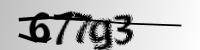

In [31]:
# 코드 3-1

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('captcha-version-2-images/samples/samples/677g3.png')
# img = Image.open('captcha-version-2-images/captcha01.png')
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [32]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    # Load Image
    img = img.convert('L')
    # Resize Image [1, 224, 224]
    img = transform(img)
    
    # Turn image into numpy array
    img = np.array(img)
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
#     # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

torch.Size([1, 1, 224, 224])


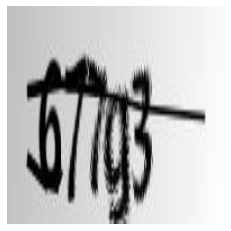

In [33]:
input = process_image('captcha-version-2-images/samples/samples/677g3.png')
print(input.size())
plt.imshow(input.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()
# image = input[:,0][:,None].type(torch.FloatTensor).to(device) # select only 1 channel (all channel equal)
# print(image.size())


In [34]:
def get_predict(model, path):

    model.eval()
    predict_label = ""
    input = process_image(path)
    print(input.size())
    
    img = Variable(input).to(device)

    output = model(img)

    c0 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    predict_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

   
    return predict_label
    


In [35]:
get_predict(new_model, 'captcha-version-2-images/samples/samples/677g3.png')

torch.Size([1, 1, 224, 224])


'677g3'